### Obtaining Data

In [395]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [396]:
final = pd.read_csv(r'../../assets/final.csv')
metadata = pd.read_csv(r'../../assets/metadata.csv')

final = final.drop(final.columns[0],
                   axis="columns")  # drop the first column of the index

final = final.set_index('track_id')

# final = final.drop(labels=["artist_hotttnesss", "artist_familiarity"], axis="columns")

In [397]:
seed = 100

In [398]:
from sklearn.preprocessing import MinMaxScaler

# create a scaler object
scaler = MinMaxScaler()
# fit and transform the data
final = pd.DataFrame(scaler.fit_transform(final), columns=final.columns)

print(final)

       acousticness  danceability    energy  instrumentalness  liveness  \
0          0.418434      0.680869  0.634492          0.010649  0.159523   
1          0.375988      0.520349  0.817487          0.001855  0.084377   
2          0.043750      0.756819  0.701489          0.000698  0.364224   
3          0.955687      0.661557  0.924557          0.967346  0.094422   
4          0.454126      0.503556  0.560421          0.019481  0.074625   
...             ...           ...       ...               ...       ...   
13124      0.007624      0.805654  0.719309          0.854809  0.728161   
13125      0.041672      0.863118  0.536506          0.866871  0.547261   
13126      0.000124      0.608695  0.895166          0.848307  0.636215   
13127      0.328959      0.570258  0.548338          0.453768  0.053014   
13128      0.997801      0.488404  0.050605          0.947556  0.073995   

       speechiness     tempo   valence  artist_discovery  artist_familiarity  \
0         0.145135 

In [399]:
# final.info()

In [400]:
# final.head(3)

In [401]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   track_id     13129 non-null  int64 
 1   album_title  13129 non-null  object
 2   artist_name  13129 non-null  object
 3   genre        13129 non-null  object
 4   track_title  13128 non-null  object
dtypes: int64(1), object(4)
memory usage: 513.0+ KB


In [402]:
# metadata.head()

### Model Selection - K Means Algorithm

In [403]:
from sklearn.utils import shuffle
import hdbscan

In [404]:
final = shuffle(final, random_state=seed)

In [405]:
num_enlisted = 100  # how many songs are enlisted in the user's playlist

# X is the audience's playlist  Recall: iloc is integer position-based
X = final.iloc[[i for i in range(0, num_enlisted)]]

# Y is the music reservoir which are going to be used for the recommendations
Y = final.iloc[[i for i in range(num_enlisted, final.shape[0])]]

In [406]:
X = shuffle(X, random_state=seed)
Y = shuffle(Y, random_state=seed)
X

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
2419,1.000000,0.707543,0.196787,0.915624,0.377304,0.020039,0.483692,0.861103,0.388639,0.091817,0.335505,0.000000,0.000000
10515,0.425710,0.546210,0.704866,0.953601,0.077707,0.014778,0.505981,0.404146,0.145124,0.153112,0.125283,0.000000,0.000000
5052,0.378446,0.545188,0.850706,0.668948,0.133428,0.054652,0.618012,0.301626,0.475881,0.343569,0.410819,0.000000,0.000000
10489,0.792795,0.429687,0.991938,0.864437,0.081194,0.014491,0.575963,0.711521,0.411667,0.285427,0.355384,0.000000,0.000000
689,0.060883,0.766558,0.333655,0.940140,0.079285,0.012514,0.554907,0.885347,0.478126,0.316784,0.412757,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8780,0.588984,0.466291,0.852470,0.826223,0.098116,0.008356,0.609784,0.963920,0.647216,0.428598,0.558730,0.001744,0.124304
2723,0.035320,0.493219,0.565304,0.615368,0.372120,0.017779,0.576026,0.208981,0.689059,0.454862,0.594852,0.000000,0.000000
4901,1.000000,0.274318,0.102068,0.950547,0.455779,0.022701,0.377784,0.188640,0.555543,0.359826,0.479590,0.000000,0.000000
8832,0.613778,0.827671,0.634824,0.927662,0.046223,0.027216,0.433369,0.659679,0.659856,0.412524,0.569642,0.000650,0.074257


In [407]:
# X.head()

In [408]:
# hdbscan_model = hdbscan.HDBSCAN(
#     algorithm='best', alpha=1.0, prediction_data=True, approx_min_span_tree=True,
#     gen_min_span_tree=False, leaf_size=40, metric='euclidean', min_cluster_size=5,
#     min_samples=None, p=None
# )

In [409]:
def fit(df, algo, flag=0):
    # df = df.set_index('track_id')
    if flag:
        algo.fit(df)
    else:
        algo.partial_fit(df)
    df['label'] = algo.labels_
    return (df, algo)

In [410]:
def predict(t, Y):
    Y = Y.set_index('track_id')
    y_pred = hdbscan.approximate_predict(t[1], Y)[0]
    mode = pd.Series(y_pred).mode()
    return t[0][t[0]['label'] == mode.loc[0]]

In [411]:
# Y.head()

In [412]:
# t[0] is the new dataframe with the new row indexes and labels of the belonged cluster
# t[1] is the HDBSCAN model after the training

cluster_num = pd.DataFrame(columns=['min_cluster_size', "num_of_clusters", "mean_probability"])
print(cluster_num)

# for size in range(5, 25):
#     hdbscan_model_vary = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size=size, prediction_data=True)
#     t = fit(X, hdbscan_model_vary, 1)
#
#     num_of_label = t[1].labels_.max() + 1
#     mean_prob = np.mean(t[1].probabilities_)
#
#     cluster_num = pd.concat(cluster_num, pd.DataFrame(
#         data={'min_cluster_size': size, "num_of_clusters": num_of_label, "mean_probability": mean_prob}),
#                             ignore_index=True)
#     # print(np.mean(t[1].probabilities_))
#
# cluster_num

Empty DataFrame
Columns: [min_cluster_size, num_of_clusters, mean_probability]
Index: []


In [413]:
# reset the fitting model for min_cluster_size=5
hdbscan_model = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size=3, prediction_data=True)
t = fit(X, hdbscan_model, 1)

In [414]:
# show the numbers of clusters in the model
print(t[1].labels_.max() + 1)

4


In [415]:
t[0].head(100)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss,label
2419,1.000000,0.707543,0.196787,0.915624,0.377304,0.020039,0.483692,0.861103,0.388639,0.091817,0.335505,0.000000,0.000000,-1
10515,0.425710,0.546210,0.704866,0.953601,0.077707,0.014778,0.505981,0.404146,0.145124,0.153112,0.125283,0.000000,0.000000,-1
5052,0.378446,0.545188,0.850706,0.668948,0.133428,0.054652,0.618012,0.301626,0.475881,0.343569,0.410819,0.000000,0.000000,2
10489,0.792795,0.429687,0.991938,0.864437,0.081194,0.014491,0.575963,0.711521,0.411667,0.285427,0.355384,0.000000,0.000000,-1
689,0.060883,0.766558,0.333655,0.940140,0.079285,0.012514,0.554907,0.885347,0.478126,0.316784,0.412757,0.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8780,0.588984,0.466291,0.852470,0.826223,0.098116,0.008356,0.609784,0.963920,0.647216,0.428598,0.558730,0.001744,0.124304,-1
2723,0.035320,0.493219,0.565304,0.615368,0.372120,0.017779,0.576026,0.208981,0.689059,0.454862,0.594852,0.000000,0.000000,-1
4901,1.000000,0.274318,0.102068,0.950547,0.455779,0.022701,0.377784,0.188640,0.555543,0.359826,0.479590,0.000000,0.000000,-1
8832,0.613778,0.827671,0.634824,0.927662,0.046223,0.027216,0.433369,0.659679,0.659856,0.412524,0.569642,0.000650,0.074257,2


[Text(0.5, 1.0, 'HDBSCAN Clustering on energy VS tempo')]

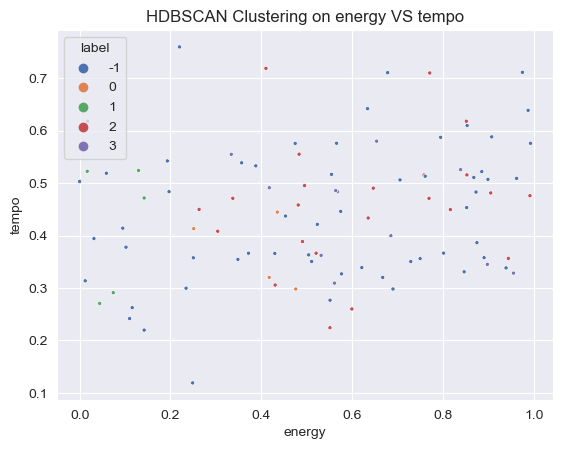

In [416]:
x_label = "energy"
y_label = "tempo"
sns.scatterplot(data=t[0], x=x_label, y=y_label, hue='label', marker=".", palette="deep").set(
    title="HDBSCAN Clustering on " + x_label + " VS " + y_label)

[Text(0.5, 1.0, 'HDBSCAN Clustering on liveness VS tempo')]

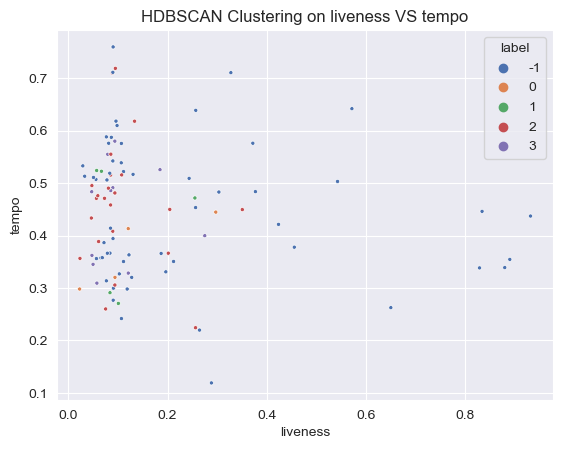

In [417]:
x_label = "liveness"
y_label = "tempo"
sns.scatterplot(data=t[0], x=x_label, y=y_label, hue='label', marker=".", palette="deep").set(
    title="HDBSCAN Clustering on " + x_label + " VS " + y_label)

[Text(0.5, 1.0, 'HDBSCAN Clustering on liveness VS speechiness')]

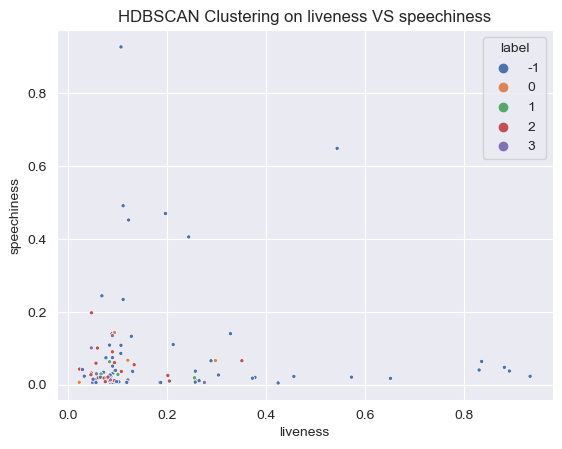

In [418]:
x_label = "liveness"
y_label = "speechiness"
sns.scatterplot(data=t[0], x=x_label, y=y_label, hue='label', marker=".", palette="deep").set(
    title="HDBSCAN Clustering on " + x_label + " VS " + y_label)

In [419]:
recommendations = predict(t, Y)

KeyError: "None of ['track_id'] are in the columns"

In [ ]:
recommendations.info()

In [ ]:
recommendations.head()

In [ ]:
metadata.info()

In [ ]:
metadata = metadata.set_index('track_id')

In [ ]:
Y.head()

In [ ]:
Y.info()

In [ ]:
#Y = Y.reset_index(level=0)

In [ ]:
#recommendations = recommendations.reset_index(level=0)

In [ ]:
def recommend(recommendations, meta, Y):
    recommendations = recommendations.reset_index(level=0)
    Y = Y.reset_index(level=0)
    dat = []
    for i in Y['track_id']:
        dat.append(i)
    genre_mode = meta.loc[dat]['genre'].mode()
    artist_mode = meta.loc[dat]['artist_name'].mode()
    return meta[meta['genre'] == genre_mode.iloc[0]], meta[meta['artist_name'] == artist_mode.iloc[0]], meta.loc[
        recommendations['track_id']]

In [ ]:
output = recommend(recommendations, metadata, Y)

In [ ]:
genre_recommend, artist_name_recommend, mixed_recommend = output[0], output[1], output[2]

In [ ]:
genre_recommend.shape

In [ ]:
artist_name_recommend.shape

In [ ]:
mixed_recommend.shape

In [ ]:
# Genre wise recommendations
genre_recommend.head()

In [ ]:
# Artist wise recommendations
artist_name_recommend.head()

In [ ]:
# Mixed Recommendations
mixed_recommend.head()

In [ ]:
recommendations

In [ ]:
artist_name_recommend['artist_name'].value_counts()

In [ ]:
genre_recommend['genre'].value_counts()

In [ ]:
genre_recommend['artist_name'].value_counts()

#### Testing

In [ ]:
testing = Y.iloc[6:12]['track_id']

In [ ]:
testing

In [ ]:
ids = testing.loc[testing.index]

In [ ]:
songs = metadata.loc[testing.loc[list(testing.index)]]

In [ ]:
songs

In [ ]:
re = predict(t, Y.iloc[6:12])

In [ ]:
output = recommend(re, metadata, Y.iloc[6:12])

In [ ]:
ge_re, ge_ar, ge_mix = output[0], output[1], output[2]

In [ ]:
ge_re.head()

In [ ]:
ge_ar.head(10)

In [ ]:
ge_mix.head(10)

In [ ]:
ge_re.shape

In [ ]:
ge_ar.shape

In [ ]:
ge_mix.shape